# NYC MTA Inclement Weather Impacts Study 

### by Nancy Binowski @nbinowski

The goal of this study is to determine if weather impacts ridership on New York City (NYC) subways. The purpose is to see if there are improvements that can be made in subway stations to weather-proof them so that customers are more likely to ride the subway in inclement weather.  

Source Data: Metropolitan Transit Authority (MTA) turnstile data for 2019, National Oceanic and Atmospheric Administration (NOAA) daily climate data for NYC in 2019


## SQL Queries
SQL is a useful tool for data storage and initial loading and investigation of data.  These are the initial queries that I ran on MTA and NOAA data.

~~~~sql
SELECT Station, Date  FROM mta_data
WHERE Station IN ('34 ST-PENN STA')
LIMIT 10;

SELECT COUNT(*)  FROM mta_data
WHERE Station IN ('34 ST-PENN STA','GRD CNTRL-42 ST', '34 ST-HERALD SQ', '23 ST', 'CANAL ST');

.mode csv
.import nyc_weather_daily_2019.csv weather_daily
.schema weather_daily
SELECT STATION, NAME, DATE FROM weather_daily;
SELECT COUNT(*) FROM weather_daily;
~~~~


Tested the opening of data, selecting one station, counting the number of records (781,010) to get overall scope of data.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import datetime

## Initial Data Exploration

### Read in MTA data, pull out subset of stations, and do some initial data exploration to determine cleaning operations.

In [2]:
# read in MTA data from SQL database
engine = create_engine("sqlite:///mta_data.db")
df = pd.read_sql('SELECT * FROM mta_data',engine)

#### Determine top 5 stations with most turnstile traffic

Over multiple weeks, sum total ridership for each station and sort
  them, to find out the stations with the highest traffic
  during 2019

##### `DAILY `time series for each `STATION`

Get daily time series for each STATION, by adding up all the turnstiles in a station.


In [50]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily

,STATION,DATE,DAILY_ENTRIES
0,23 ST,2019-01-03,112899.0
1,23 ST,2019-01-04,111123.0
2,23 ST,2019-01-05,47246.0
3,23 ST,2019-01-06,37478.0
4,23 ST,2019-01-07,109785.0
...,...,...,...
1790,GRD CNTRL-42 ST,2019-12-23,117962.0
1791,GRD CNTRL-42 ST,2019-12-24,81514.0
1792,GRD CNTRL-42 ST,2019-12-25,34227.0
1793,GRD CNTRL-42 ST,2019-12-26,94916.0


In [51]:
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

station_totals.head()

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,51747354.0
1,GRD CNTRL-42 ST,44630664.0
2,34 ST-HERALD SQ,39100696.0
3,23 ST,35698864.0
4,CANAL ST,23841423.0


In [52]:
# Filter station to contain the 5 top traffic station data only
station_list = ['34 ST-PENN STA','GRD CNTRL-42 ST', '34 ST-HERALD SQ', '23 ST', 'CANAL ST']
stations = df[df.STATION.isin(station_list) ]
stations.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
10627533,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,01/04/2019,08:00:00,REGULAR,486503,18882
10627534,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,01/04/2019,11:35:18,REGULAR,486608,18892
10627535,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,01/04/2019,12:00:00,REGULAR,486616,18892
10627536,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,01/04/2019,16:00:00,REGULAR,486731,18896
10627537,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,01/04/2019,20:00:00,REGULAR,487529,18902


In [53]:
#check to see if there is missing data
stations.count()

C/A         781010
UNIT        781010
SCP         781010
STATION     781010
LINENAME    781010
DIVISION    781010
DATE        781010
TIME        781010
DESC        781010
ENTRIES     781010
EXITS       781010
dtype: int64

In [54]:
# check for errors in column names
stations.columns


Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [6]:
# no need to strip column names (SQLite must have cleaned it!)

In [55]:
stations.DATE.value_counts().sort_index()

01/01/2019    2100
01/02/2019    2095
01/03/2019    2099
01/04/2019    2230
01/05/2019    2083
              ... 
12/26/2019    2142
12/27/2019    2146
12/29/2018    2097
12/30/2018    2096
12/31/2018    2123
Name: DATE, Length: 364, dtype: int64

In [56]:
stations["DATE_TIME"] = pd.to_datetime(stations.DATE + " " + stations.TIME, format="%m/%d/%Y %H:%M:%S")

/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/3468687085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations["DATE_TIME"] = pd.to_datetime(stations.DATE + " " + stations.TIME, format="%m/%d/%Y %H:%M:%S")


In [57]:
stations.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
3106,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/21/2019,03:00:00,REGULAR,28139085,11742732,2019-12-21 03:00:00
3107,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/21/2019,07:00:00,REGULAR,28139121,11742771,2019-12-21 07:00:00
3108,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/21/2019,11:00:00,REGULAR,28139396,11743094,2019-12-21 11:00:00
3109,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/21/2019,15:00:00,REGULAR,28140359,11743867,2019-12-21 15:00:00
3110,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/21/2019,19:00:00,REGULAR,28141948,11744601,2019-12-21 19:00:00


### Read in NOAA daily climate data and do some initial data exploration

In [58]:
# read in daily weather data from NOAA data for NYC weather station
weather_daily = pd.read_csv("nyc_weather_daily_2019.csv",parse_dates=['DATE'])

In [59]:
weather_daily.head()


,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-01-01,NaN,NaN,0.06,0.0,0.0,NaN,58,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-01-02,NaN,NaN,0.00,0.0,0.0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-01-03,NaN,NaN,0.00,0.0,0.0,NaN,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-01-04,NaN,NaN,0.00,0.0,0.0,NaN,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2019-01-05,NaN,NaN,0.50,0.0,0.0,NaN,47,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [60]:
weather_daily.count()

STATION    365
NAME       365
DATE       365
AWND       296
PGTM         0
PRCP       365
SNOW       365
SNWD       365
TAVG         0
TMAX       365
TMIN       365
TSUN         0
WDF2       296
WDF5       295
WSF2       296
WSF5       295
WT01       156
WT02         9
WT03        30
WT04         0
WT06         6
WT08        57
dtype: int64

In [61]:
weather_daily.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   STATION  365 non-null    object        
 1   NAME     365 non-null    object        
 2   DATE     365 non-null    datetime64[ns]
 3   AWND     296 non-null    float64       
 4   PGTM     0 non-null      float64       
 5   PRCP     365 non-null    float64       
 6   SNOW     365 non-null    float64       
 7   SNWD     365 non-null    float64       
 8   TAVG     0 non-null      float64       
 9   TMAX     365 non-null    int64         
 10  TMIN     365 non-null    int64         
 11  TSUN     0 non-null      float64       
 12  WDF2     296 non-null    float64       
 13  WDF5     295 non-null    float64       
 14  WSF2     296 non-null    float64       
 15  WSF5     295 non-null    float64       
 16  WT01     156 non-null    float64       
 17  WT02     9 non-null      float64   

In [62]:
#remove data not needed (windspeed, empty data fields)
del_weather_cols = ['PGTM','TAVG','TSUN','WDF2','WDF5','WSF2', 'WSF5','AWND','WT01','WT02','WT03','WT04','WT06','WT08']
weather_daily = weather_daily.drop(del_weather_cols, axis=1, errors="ignore")

In [63]:
weather_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   STATION  365 non-null    object        
 1   NAME     365 non-null    object        
 2   DATE     365 non-null    datetime64[ns]
 3   PRCP     365 non-null    float64       
 4   SNOW     365 non-null    float64       
 5   SNWD     365 non-null    float64       
 6   TMAX     365 non-null    int64         
 7   TMIN     365 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 22.9+ KB


### Find the top 5 hot, cold, rainy, snow days to perhaps drill down
\* Note:  information used to pick out important days to notice in results

In [65]:
top_5_hotest_days = weather_daily.sort_values(by=['TMAX'], ascending=False).head(5).DATE
top_5_hotest_days

201   2019-07-21
200   2019-07-20
197   2019-07-17
274   2019-10-02
210   2019-07-30
Name: DATE, dtype: datetime64[ns]

In [66]:
top_5_coldest_days = weather_daily.sort_values(by=['TMIN']).head(5).DATE
top_5_coldest_days

30   2019-01-31
20   2019-01-21
29   2019-01-30
31   2019-02-01
21   2019-01-22
Name: DATE, dtype: datetime64[ns]

In [67]:
top_5_rainy_days = weather_daily.sort_values(by=['PRCP'], ascending=False).head(5).DATE
top_5_rainy_days

288   2019-10-16
197   2019-07-17
202   2019-07-22
342   2019-12-09
299   2019-10-27
Name: DATE, dtype: datetime64[ns]

In [68]:
top_5_snow_days = weather_daily.sort_values(by=['SNOW'], ascending=False).head(5).DATE
top_5_snow_days

60   2019-03-02
61   2019-03-03
62   2019-03-04
59   2019-03-01
50   2019-02-20
Name: DATE, dtype: datetime64[ns]

### Diagnostics Check
Run some diagnostics on the data and see approaches to cleaning 

Isolate specific turnstiles by creating boolean series masks, then use them to index into the dataframe: 

In [70]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(stations
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
758534,R240,R047,00-03-04,GRD CNTRL-42 ST,2019-11-27 00:00:00,2
203781,N071,R013,00-00-00,34 ST-PENN STA,2019-02-27 19:00:00,2
208173,N071,R013,00-00-02,34 ST-PENN STA,2019-02-27 23:00:00,2
208488,N071,R013,00-00-02,34 ST-PENN STA,2019-04-20 08:00:00,2
208174,N071,R013,00-00-02,34 ST-PENN STA,2019-02-28 03:00:00,2


In [71]:
stations.DESC.value_counts()

REGULAR       776745
RECOVR AUD      4265
Name: DESC, dtype: int64

In [72]:
# Get rid of the duplicate entry
stations.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
stations.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [73]:
stations.isna().sum()

C/A          0
UNIT         0
SCP          0
STATION      0
LINENAME     0
DIVISION     0
DATE         0
TIME         0
DESC         0
ENTRIES      0
EXITS        0
DATE_TIME    0
dtype: int64

In [74]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(stations
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A022,R022,01-00-00,34 ST-HERALD SQ,2018-12-29 03:00:00,1
520641,R138,R293,00-02-05,34 ST-PENN STA,2019-06-19 14:00:00,1
520632,R138,R293,00-02-05,34 ST-PENN STA,2019-06-18 02:00:00,1
520633,R138,R293,00-02-05,34 ST-PENN STA,2019-06-18 06:00:00,1
520634,R138,R293,00-02-05,34 ST-PENN STA,2019-06-18 10:00:00,1


In [75]:
# Drop Unneeded Columns.  To prevent errors in multiple run of cell, errors on drop is ignored
del_cols = ["EXITS","DESC","LINENAME","DIVISION"]
stations = stations.drop(del_cols, axis=1, errors="ignore")

In [76]:
#discovered MTA data from 2018 - remove it
mask = (stations["DATE_TIME"].dt.year == 2019)
stations = stations[mask]
stations

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,DATE_TIME
161787,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/27/2019,20:00:00,837110,2019-12-27 20:00:00
161786,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/27/2019,16:00:00,836635,2019-12-27 16:00:00
161785,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/27/2019,12:00:00,836521,2019-12-27 12:00:00
161784,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/27/2019,08:00:00,836441,2019-12-27 08:00:00
161783,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/27/2019,04:00:00,836432,2019-12-27 04:00:00
...,...,...,...,...,...,...,...,...
10473428,A022,R022,01-00-00,34 ST-HERALD SQ,01/01/2019,19:00:00,26325345,2019-01-01 19:00:00
10473427,A022,R022,01-00-00,34 ST-HERALD SQ,01/01/2019,15:00:00,26324298,2019-01-01 15:00:00
10473426,A022,R022,01-00-00,34 ST-HERALD SQ,01/01/2019,11:00:00,26323640,2019-01-01 11:00:00
10473425,A022,R022,01-00-00,34 ST-HERALD SQ,01/01/2019,07:00:00,26323469,2019-01-01 07:00:00


### Get individual daily turnstile data
- Each combination of `C/A`, `UNIT`, `SCP`, and `STATION` represents a unique turnstile. 
- Obtain the maximum `ENTRIES` value for each day, for each unique turnstile.

Each row represents a turnstile (identified by a combination of  the `C/A`, `UNIT`, `SCP`, and `STATION` columns) at a specific time -- approximately four hours apart. The `ENTRIES` column represents **cumulative entries** at that point in time.

The maximum `ENTRIES` value would occur at the last reading of the day. Since rows are listed in descending order of time, grab the last reading of the day (located at the top of the group) using the `.first()` DataFrame method.

In [77]:
turnstiles_daily = (stations
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [78]:
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A022,R022,01-00-00,34 ST-HERALD SQ,01/01/2019,26326240
1,A022,R022,01-00-00,34 ST-HERALD SQ,01/02/2019,26331769
2,A022,R022,01-00-00,34 ST-HERALD SQ,01/03/2019,26337202
3,A022,R022,01-00-00,34 ST-HERALD SQ,01/04/2019,26342449
4,A022,R022,01-00-00,34 ST-HERALD SQ,01/05/2019,26345270
...,...,...,...,...,...,...
126986,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/23/2019,835317
126987,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/24/2019,835807
126988,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/25/2019,835850
126989,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/26/2019,836390


### Get `DAILY_ENTRIES` for each turnstile



- Work off of the daily maximum `ENTRIES` calculations. `ENTRIES` column contains 
**cumulative entries** on each day. Calculate **daily entries**, i.e. the number of new entries gained each day.
- Group the data by turnstile and use the Pandas `.apply()` method to compute the same differencing function for each turnstile.

In [83]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_daily['PREV_DATE'] = pd.to_datetime(turnstiles_daily['PREV_DATE'])


/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/1258312435.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [84]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A022,R022,01-00-00,34 ST-HERALD SQ,01/01/2019,26326240,NaT,NaN
1,A022,R022,01-00-00,34 ST-HERALD SQ,01/02/2019,26331769,2019-01-01,26326240.0
2,A022,R022,01-00-00,34 ST-HERALD SQ,01/03/2019,26337202,2019-01-02,26331769.0
3,A022,R022,01-00-00,34 ST-HERALD SQ,01/04/2019,26342449,2019-01-03,26337202.0
4,A022,R022,01-00-00,34 ST-HERALD SQ,01/05/2019,26345270,2019-01-04,26342449.0


In [85]:
turnstiles_daily.tail()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
126986,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/23/2019,835317,2019-12-22,834454.0
126987,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/24/2019,835807,2019-12-23,835317.0
126988,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/25/2019,835850,2019-12-24,835807.0
126989,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/26/2019,836390,2019-12-25,835850.0
126990,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/27/2019,837110,2019-12-26,836390.0


In [86]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [34]:
# Change the data type of PREV_ENTRIES TO MATCH ENTRIES
turnstiles_daily.astype({'PREV_ENTRIES':'int64'})


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A022,R022,01-00-00,34 ST-HERALD SQ,01/02/2019,26331769,01/01/2019,26326240
2,A022,R022,01-00-00,34 ST-HERALD SQ,01/03/2019,26337202,01/02/2019,26331769
3,A022,R022,01-00-00,34 ST-HERALD SQ,01/04/2019,26342449,01/03/2019,26337202
4,A022,R022,01-00-00,34 ST-HERALD SQ,01/05/2019,26345270,01/04/2019,26342449
5,A022,R022,01-00-00,34 ST-HERALD SQ,01/06/2019,26348039,01/05/2019,26345270
...,...,...,...,...,...,...,...,...
126986,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/23/2019,835317,12/22/2019,834454
126987,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/24/2019,835807,12/23/2019,835317
126988,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/25/2019,835850,12/24/2019,835807
126989,R241A,R048,00-00-04,GRD CNTRL-42 ST,12/26/2019,836390,12/25/2019,835850


In [87]:
#drop rows where there was a gap from PREV_DATE
turnstiles_daily['DATE'] = pd.to_datetime(turnstiles_daily['DATE'])
# #turnstiles_daily['GAP'] = ((turnstiles_daily['DATE'] - turnstiles_daily['PREV_DATE']) != '1 days 00:00:00')
turnstiles_daily.drop(
    turnstiles_daily[((turnstiles_daily['DATE'] - turnstiles_daily['PREV_DATE']) != '1 days 00:00:00')==True].index,
    inplace=True)

# turnstiles_daily.drop(turnstiles_daily[turnstiles_daily['GAP']==True].index, inplace = True)
turnstiles_daily


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-02,26331769,2019-01-01,26326240.0
2,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-03,26337202,2019-01-02,26331769.0
3,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-04,26342449,2019-01-03,26337202.0
4,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-05,26345270,2019-01-04,26342449.0
5,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-06,26348039,2019-01-05,26345270.0
...,...,...,...,...,...,...,...,...
126986,R241A,R048,00-00-04,GRD CNTRL-42 ST,2019-12-23,835317,2019-12-22,834454.0
126987,R241A,R048,00-00-04,GRD CNTRL-42 ST,2019-12-24,835807,2019-12-23,835317.0
126988,R241A,R048,00-00-04,GRD CNTRL-42 ST,2019-12-25,835850,2019-12-24,835807.0
126989,R241A,R048,00-00-04,GRD CNTRL-42 ST,2019-12-26,836390,2019-12-25,835850.0


### Investigate Reverse Entries


In [88]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].tail()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
119945,R238A,R046,02-03-00,GRD CNTRL-42 ST,2019-11-14,4976,2019-11-13,5010.0
120677,R238A,R046,02-03-02,GRD CNTRL-42 ST,2019-11-24,2528,2019-11-23,2885384.0
123371,R240,R047,00-03-04,GRD CNTRL-42 ST,2019-11-26,3953156,2019-11-25,15763173.0
126369,R241A,R048,00-00-03,GRD CNTRL-42 ST,2019-04-11,2319,2019-04-10,789868.0
126464,R241A,R048,00-00-03,GRD CNTRL-42 ST,2019-07-15,170,2019-07-14,139740.0


In [92]:
# Look at a specific example 
mask = ((stations["C/A"] == "R240") & 
(stations["UNIT"] == "R047") & 
(stations["SCP"] == "00-03-04") & 
(stations["STATION"] == "GRD CNTRL-42 ST") &
(stations["DATE_TIME"].dt.date == datetime.datetime(2019, 11, 26).date()))
stations[mask].head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,DATE_TIME
985756,R240,R047,00-03-04,GRD CNTRL-42 ST,11/26/2019,20:00:00,3953156,2019-11-26 20:00:00
985754,R240,R047,00-03-04,GRD CNTRL-42 ST,11/26/2019,16:00:00,15763177,2019-11-26 16:00:00
985752,R240,R047,00-03-04,GRD CNTRL-42 ST,11/26/2019,12:00:00,3953156,2019-11-26 12:00:00
985750,R240,R047,00-03-04,GRD CNTRL-42 ST,11/26/2019,08:00:00,3953156,2019-11-26 08:00:00
985749,R240,R047,00-03-04,GRD CNTRL-42 ST,11/26/2019,07:33:37,3953156,2019-11-26 07:33:37


* Counter is not incrementing 

In [91]:
# How many stations have this problem?

(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A025   R023  01-03-01  34 ST-HERALD SQ    360
A030   R083  01-00-00  23 ST                1
A031   R083  00-03-02  23 ST                2
A043   R462  00-03-03  CANAL ST             1
             00-06-00  CANAL ST             1
                                         ... 
R238A  R046  02-00-00  GRD CNTRL-42 ST      2
             02-03-00  GRD CNTRL-42 ST      2
             02-03-02  GRD CNTRL-42 ST      1
R240   R047  00-03-04  GRD CNTRL-42 ST      1
R241A  R048  00-00-03  GRD CNTRL-42 ST      2
Length: 74, dtype: int64

In [93]:
#Create a function to clean the issues when the counter is being reset or has some excessively large jump from previous day
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 20,000, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=20000)

1443 7054160.0
1261 3875856.0
1009 334675.0
724 3557590.0
458941 950058.0
1034 127369.0
1296 1949564336.0
458818 12875905.0
722499 458818.0
459313 11321306.0
524915 566353.0
559 2225874.0
459625 2908210.0
1797 1973399.0
878 1360328.0
1132 201981.0
3019 5389064.0
589824 0.0
458752 589824.0
954 6879812.0
107 1068192.0
2196693 5869413.0
5871517 2196693.0
1473 5925049.0
5927279 1473.0
2224575 3171521.0
3172932 2224575.0
2267657 3211131.0
3212888 2267657.0
8416216 3031855.0
3033376 8416216.0
8480234 3070412.0
3072147 8480234.0
1776810 5099614.0
5101826 1776810.0
1856335 5153313.0
5155435 1856335.0
10585172 669641.0
673305 10585172.0
10668361 762437.0
765949 10668361.0
458770 589970.0
590456 458770.0
458907 601697.0
602119 458907.0
196609 262559.0
2567 152966689.0
2204 19783118.0
131075 2222463.0
66 1081440.0
459063 4526857.0
1201 4720992.0
2526 6920350.0
2191 191115.0
1610 582600.0
1376698 1257771.0
421 1376698.0
383 638294.0
440 42416.0
147 3663710.0
583 200806.0
323 6061205.0
688 304878.0

In [94]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-02,26331769,2019-01-01,26326240.0,5529.0
2,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-03,26337202,2019-01-02,26331769.0,5433.0
3,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-04,26342449,2019-01-03,26337202.0,5247.0
4,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-05,26345270,2019-01-04,26342449.0,2821.0
5,A022,R022,01-00-00,34 ST-HERALD SQ,2019-01-06,26348039,2019-01-05,26345270.0,2769.0


# Plotting the data for exploration and observation



Plot the weather time series for high and low temperatures, precipitation and snow.  Also plot the daily time series for each station.



In [95]:
%matplotlib inline
import matplotlib.pyplot as plt

## Weather Plots

Look at basic plots of key weather data: Precipitation (PRCP), Snow (SNOW), Snow Depth (SNWD), Temperature Highs (TMAX) and Temperature Lows (TMIN)

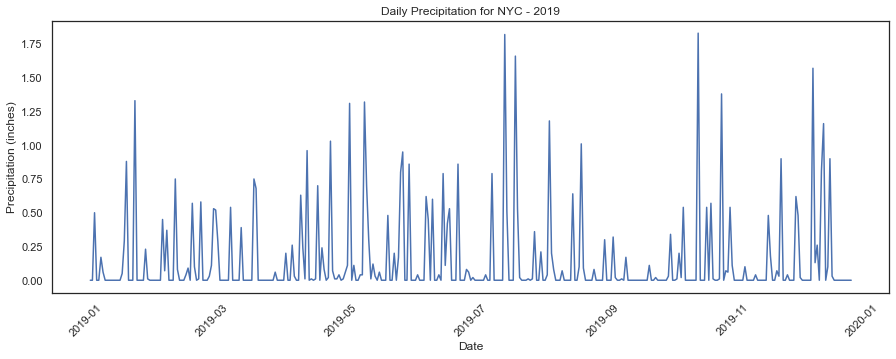

In [168]:
plt.figure(figsize=(15,5))
plt.plot(weather_daily['DATE'], weather_daily['PRCP'])
plt.ylabel('Precipitation (inches)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Precipitation for NYC - 2019')
plt.savefig('daily_prcp.jpg')

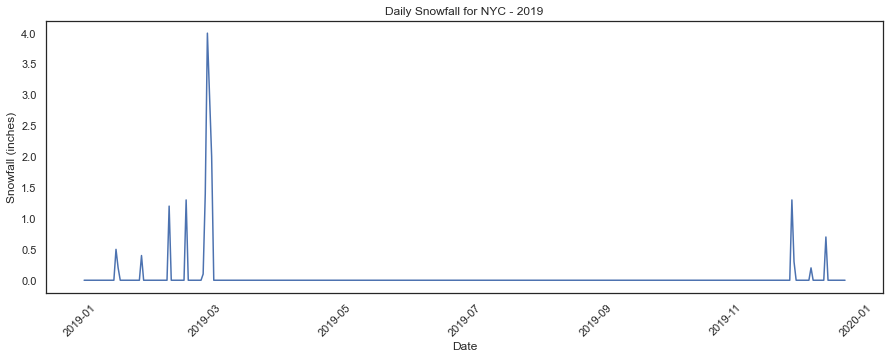

In [170]:
plt.figure(figsize=(15,5))
plt.plot(weather_daily['DATE'], weather_daily['SNOW'])
plt.ylabel('Snowfall (inches)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Snowfall for NYC - 2019')
plt.savefig('daily_snow.jpg')

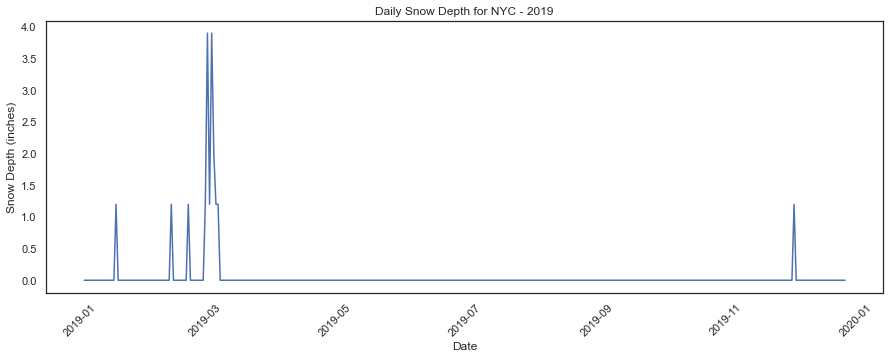

In [171]:
plt.figure(figsize=(15,5))
plt.plot(weather_daily['DATE'], weather_daily['SNWD'])
plt.ylabel('Snow Depth (inches)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Snow Depth for NYC - 2019')
plt.savefig('daily_snow_depth.jpg')

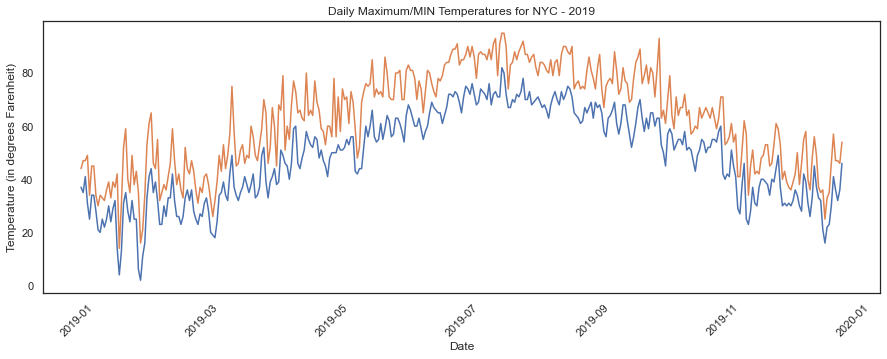

In [172]:
plt.figure(figsize=(15,5))
plt.plot(weather_daily['DATE'], weather_daily['TMIN'])
plt.plot(weather_daily['DATE'], weather_daily['TMAX'])
plt.ylabel('Temperature (in degrees Farenheit)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Maximum/MIN Temperatures for NYC - 2019')
plt.savefig('daily_temps.jpg')

## Station Plots

Show time series of `DAILY_ENTRIES` for each of the 5 stations

### 23rd Street Station 

In [115]:
twenty_third_station = station_daily[(station_daily["STATION"] == "23 ST")]

twenty_third_station['DATE'] = pd.to_datetime(twenty_third_station['DATE'])


/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/1164488736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_third_station['DATE'] = pd.to_datetime(twenty_third_station['DATE'])


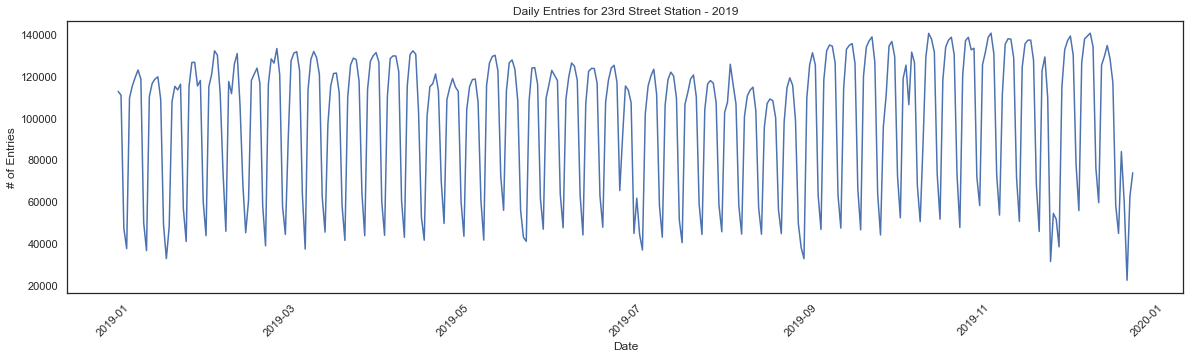

In [173]:
plt.figure(figsize=(20,5))
plt.plot(twenty_third_station['DATE'], twenty_third_station['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for 23rd Street Station - 2019')
plt.savefig('daily_entries_23st.jpg')

#### Analyze top `DAILY_ENTRIES` for purposes of cleaning data

In [117]:
top_12_daily_23st_station = twenty_third_station.sort_values('DAILY_ENTRIES',ascending=False).head(12)
top_12_daily_23st_station

,STATION,DATE,DAILY_ENTRIES
308,23 ST,2019-11-07,140862.0
343,23 ST,2019-12-12,140852.0
286,23 ST,2019-10-16,140763.0
336,23 ST,2019-12-05,139477.0
342,23 ST,2019-12-11,139476.0
266,23 ST,2019-09-26,139059.0
294,23 ST,2019-10-24,138912.0
307,23 ST,2019-11-06,138873.0
300,23 ST,2019-10-30,138869.0
314,23 ST,2019-11-13,138156.0


In [118]:
#investigate large values to validate them
test_date = datetime.datetime(2019,5,14)
turnstiles_daily['DATE'] = pd.to_datetime(turnstiles_daily.DATE)
mask = ((turnstiles_daily["STATION"] == "23 ST") &
        (turnstiles_daily["C/A"] == "R227") &
        (turnstiles_daily["SCP"] == "00-00-01") &
        #(turnstiles_daily["DATE"].dt.date == test_date.date()))
        (turnstiles_daily["DATE"].dt.month == test_date.month))

temp = turnstiles_daily[mask]
temp
#temp.sort_values('DAILY_ENTRIES',ascending=False)
#temp.sort_values('DAILY_ENTRIES',ascending=False).groupby(['C/A','UNIT','SCP']).DAILY_ENTRIES.max()



,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
98536,R227,R131,00-00-01,23 ST,2019-05-01,94178,2019-04-30,90600.0,3578.0
98537,R227,R131,00-00-01,23 ST,2019-05-02,97675,2019-05-01,94178.0,3497.0
98538,R227,R131,00-00-01,23 ST,2019-05-03,98671,2019-05-02,97675.0,996.0
98539,R227,R131,00-00-01,23 ST,2019-05-04,99449,2019-05-03,98671.0,778.0
98540,R227,R131,00-00-01,23 ST,2019-05-05,100073,2019-05-04,99449.0,624.0
98541,R227,R131,00-00-01,23 ST,2019-05-06,102288,2019-05-05,100073.0,2215.0
98542,R227,R131,00-00-01,23 ST,2019-05-07,104259,2019-05-06,102288.0,1971.0
98543,R227,R131,00-00-01,23 ST,2019-05-08,106489,2019-05-07,104259.0,2230.0
98544,R227,R131,00-00-01,23 ST,2019-05-09,108023,2019-05-08,106489.0,1534.0
98545,R227,R131,00-00-01,23 ST,2019-05-10,109331,2019-05-09,108023.0,1308.0


### Penn Station

/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/3893441218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penn_station['DATE'] = pd.to_datetime(penn_station['DATE'])


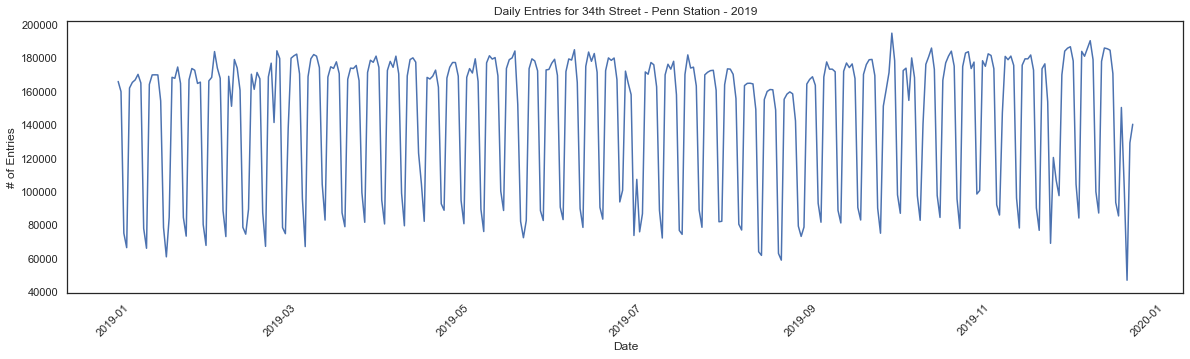

In [174]:
penn_station = station_daily[(station_daily["STATION"] == "34 ST-PENN STA")]

penn_station['DATE'] = pd.to_datetime(penn_station['DATE'])

plt.figure(figsize=(20,5))
plt.plot(penn_station['DATE'], penn_station['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34th Street - Penn Station - 2019')
plt.savefig('daily_entries_penn.jpg')

In [121]:
top_12_daily_penn_station = penn_station.sort_values('DAILY_ENTRIES',ascending=False).head(12)
top_12_daily_penn_station

,STATION,DATE,DAILY_ENTRIES
991,34 ST-PENN STA,2019-10-03,194731.0
1061,34 ST-PENN STA,2019-12-12,190224.0
1054,34 ST-PENN STA,2019-12-05,186602.0
1066,34 ST-PENN STA,2019-12-17,185843.0
1005,34 ST-PENN STA,2019-10-17,185811.0
1053,34 ST-PENN STA,2019-12-04,185729.0
1060,34 ST-PENN STA,2019-12-11,185641.0
1067,34 ST-PENN STA,2019-12-18,185413.0
879,34 ST-PENN STA,2019-06-13,184813.0
1068,34 ST-PENN STA,2019-12-19,184558.0


### Grand Central Station

/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/3717791348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grand_central_station['DATE'] = pd.to_datetime(grand_central_station['DATE'])


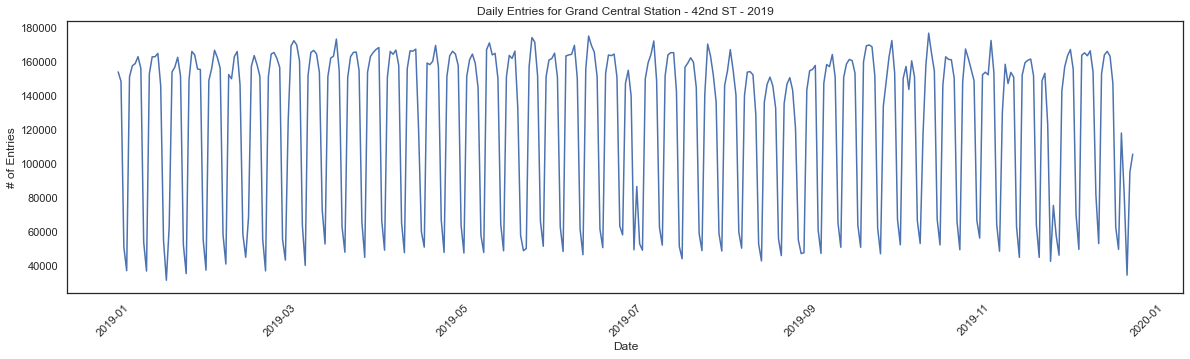

In [175]:
grand_central_station = station_daily[(station_daily["STATION"] == "GRD CNTRL-42 ST")]

grand_central_station['DATE'] = pd.to_datetime(grand_central_station['DATE'])

plt.figure(figsize=(20,5))
plt.plot(grand_central_station['DATE'], grand_central_station['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for Grand Central Station - 42nd ST - 2019')
plt.savefig('daily_entries_grandcentral.jpg')

In [123]:
top_12_daily_grand_central = grand_central_station.sort_values('DAILY_ENTRIES',ascending=False).head(12)
top_12_daily_grand_central

,STATION,DATE,DAILY_ENTRIES
1722,GRD CNTRL-42 ST,2019-10-16,176789.0
1602,GRD CNTRL-42 ST,2019-06-18,175072.0
1582,GRD CNTRL-42 ST,2019-05-29,174191.0
1513,GRD CNTRL-42 ST,2019-03-21,173299.0
1744,GRD CNTRL-42 ST,2019-11-07,172506.0
1709,GRD CNTRL-42 ST,2019-10-03,172436.0
1498,GRD CNTRL-42 ST,2019-03-06,172360.0
1625,GRD CNTRL-42 ST,2019-07-11,172185.0
1583,GRD CNTRL-42 ST,2019-05-30,171505.0
1567,GRD CNTRL-42 ST,2019-05-14,171057.0


### Herald Square Station - 34th Street

/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/3012069195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herald_square_station['DATE'] = pd.to_datetime(herald_square_station['DATE'])


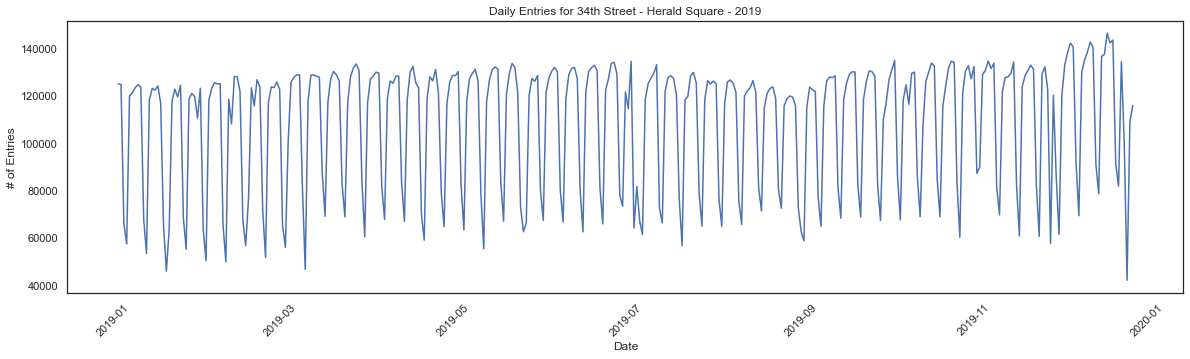

In [176]:
herald_square_station = station_daily[(station_daily["STATION"] == "34 ST-HERALD SQ")]

herald_square_station['DATE'] = pd.to_datetime(herald_square_station['DATE'])

plt.figure(figsize=(20,5))
plt.plot(herald_square_station['DATE'], herald_square_station['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34th Street - Herald Square - 2019')
plt.savefig('daily_entries_heraldsquare.jpg')

In [125]:
top_12_daily_herald_square = herald_square_station.sort_values('DAILY_ENTRIES',ascending=False).head(12)
top_12_daily_herald_square

,STATION,DATE,DAILY_ENTRIES
708,34 ST-HERALD SQ,2019-12-18,146485.0
710,34 ST-HERALD SQ,2019-12-20,143583.0
702,34 ST-HERALD SQ,2019-12-12,142712.0
709,34 ST-HERALD SQ,2019-12-19,142354.0
695,34 ST-HERALD SQ,2019-12-05,142294.0
696,34 ST-HERALD SQ,2019-12-06,140659.0
703,34 ST-HERALD SQ,2019-12-13,140478.0
701,34 ST-HERALD SQ,2019-12-11,138423.0
694,34 ST-HERALD SQ,2019-12-04,138199.0
707,34 ST-HERALD SQ,2019-12-17,137475.0


### Canal Street Station

/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/1569974317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canal_st_station['DATE'] = pd.to_datetime(canal_st_station['DATE'])


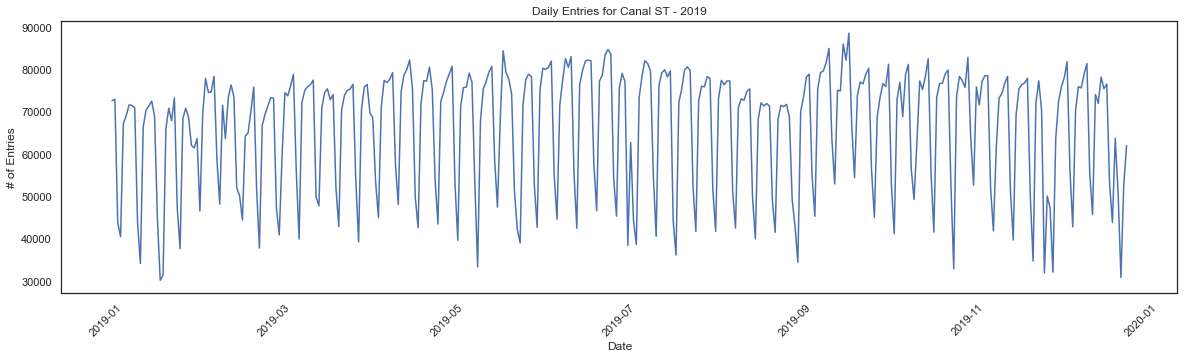

In [177]:
canal_st_station = station_daily[(station_daily["STATION"] == "CANAL ST")]

canal_st_station['DATE'] = pd.to_datetime(canal_st_station['DATE'])

plt.figure(figsize=(20,5))
plt.plot(canal_st_station['DATE'], canal_st_station['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for Canal ST - 2019')
plt.savefig('daily_entries_canalst.jpg')

In [129]:
top_12_daily_canal_st = canal_st_station.sort_values('DAILY_ENTRIES',ascending=False).head(12)
top_12_daily_canal_st

,STATION,DATE,DAILY_ENTRIES
1337,CANAL ST,2019-09-20,88616.0
1335,CANAL ST,2019-09-18,86046.0
1330,CANAL ST,2019-09-13,85002.0
1252,CANAL ST,2019-06-27,84754.0
1215,CANAL ST,2019-05-21,84441.0
1253,CANAL ST,2019-06-28,83632.0
1251,CANAL ST,2019-06-26,83549.0
1239,CANAL ST,2019-06-14,83098.0
1379,CANAL ST,2019-11-01,82893.0
1237,CANAL ST,2019-06-12,82601.0


In [130]:
#investigate large values to validate them

test_date = datetime.datetime(2019,2,27)
turnstiles_daily['DATE'] = pd.to_datetime(turnstiles_daily.DATE)
mask = ((turnstiles_daily["STATION"] == "CANAL ST") &
        (turnstiles_daily["C/A"] == "A066") &
        (turnstiles_daily["SCP"] == "00-00-01") &
        #(turnstiles_daily["DATE"].dt.date == test_date.date()))
        (turnstiles_daily["DATE"].dt.month == test_date.month))

temp = turnstiles_daily[mask]
temp
#temp.sort_values('DAILY_ENTRIES',ascending=False)
#temp.sort_values('DAILY_ENTRIES',ascending=False).groupby(['C/A','UNIT','SCP']).DAILY_ENTRIES.max()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
21694,A066,R118,00-00-01,CANAL ST,2019-02-01,9171084,2019-01-31,9170339.0,745.0
21695,A066,R118,00-00-01,CANAL ST,2019-02-02,9178787,2019-02-01,9171084.0,7703.0
21696,A066,R118,00-00-01,CANAL ST,2019-02-03,9183071,2019-02-02,9178787.0,4284.0
21697,A066,R118,00-00-01,CANAL ST,2019-02-04,9187092,2019-02-03,9183071.0,4021.0
21698,A066,R118,00-00-01,CANAL ST,2019-02-05,9191746,2019-02-04,9187092.0,4654.0
21699,A066,R118,00-00-01,CANAL ST,2019-02-06,9195851,2019-02-05,9191746.0,4105.0
21700,A066,R118,00-00-01,CANAL ST,2019-02-07,9199839,2019-02-06,9195851.0,3988.0
21701,A066,R118,00-00-01,CANAL ST,2019-02-08,9204072,2019-02-07,9199839.0,4233.0
21702,A066,R118,00-00-01,CANAL ST,2019-02-09,9208818,2019-02-08,9204072.0,4746.0
21703,A066,R118,00-00-01,CANAL ST,2019-02-10,9212953,2019-02-09,9208818.0,4135.0


### See if there are many dates that stick out as being top traffic dates across the 5 stations

In [131]:
top_12_daily = pd.concat([top_12_daily_canal_st, top_12_daily_grand_central, top_12_daily_penn_station, top_12_daily_herald_square, top_12_daily_23st_station], ignore_index=True)
top_12_daily.groupby('DATE').nunique()

,STATION,DAILY_ENTRIES
DATE,,
2019-02-28,1,1
2019-03-06,1,1
2019-03-07,1,1
2019-03-21,1,1
2019-05-14,1,1
2019-05-21,1,1
2019-05-23,1,1
2019-05-29,1,1
2019-05-30,1,1


Nothing sticks out

# Correlation Analysis
Determine if there is any relationship between temperature and ridership, precipation and ridership, and/or snow and ridership.

In [132]:
all_stations = pd.concat([canal_st_station, grand_central_station, penn_station, herald_square_station, twenty_third_station], ignore_index=True)
all_stations_daily = all_stations.sort_values('DATE').groupby('DATE').sum().reset_index()
all_stations_daily.columns

Index(['DATE', 'DAILY_ENTRIES'], dtype='object')

### There is a significant difference between weekday and weekend ridership. There is also a significant drop off of traffic on Federal Holidays.  Drop the weekend and holiday data and focus on weekday traffic only.

In [133]:
# Remove weekends and holidays
all_stations_weekday = all_stations_daily[all_stations_daily['DATE'].dt.dayofweek.isin([0,1,2,3,4])]
holidays_2019=['1/21/2019','12/25/2019','11/28/2019','7/4/2019','5/27/2019','9/2/2019','2/18/2019']
holidays_2019 = pd.to_datetime(holidays_2019)

all_stations_weekday_nh = all_stations_weekday[((all_stations_weekday['DATE'].dt.date != holidays_2019[0]) &
                     (all_stations_weekday['DATE'].dt.date != holidays_2019[1]) &
                     (all_stations_weekday['DATE'].dt.date != holidays_2019[2]) &
                     (all_stations_weekday['DATE'].dt.date != holidays_2019[3]) &
                     (all_stations_weekday['DATE'].dt.date != holidays_2019[4]) &
                     (all_stations_weekday['DATE'].dt.date != holidays_2019[5])&
                     (all_stations_weekday['DATE'].dt.date != holidays_2019[6])) == True
                    ]
# all_stations_weekday_nh = all_stations_weekday[all_stations_weekday['DATE'].dt.date.isin( holidays_2019)==False]
all_stations_weekday_nh.count()

/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


DATE             250
DAILY_ENTRIES    250
dtype: int64

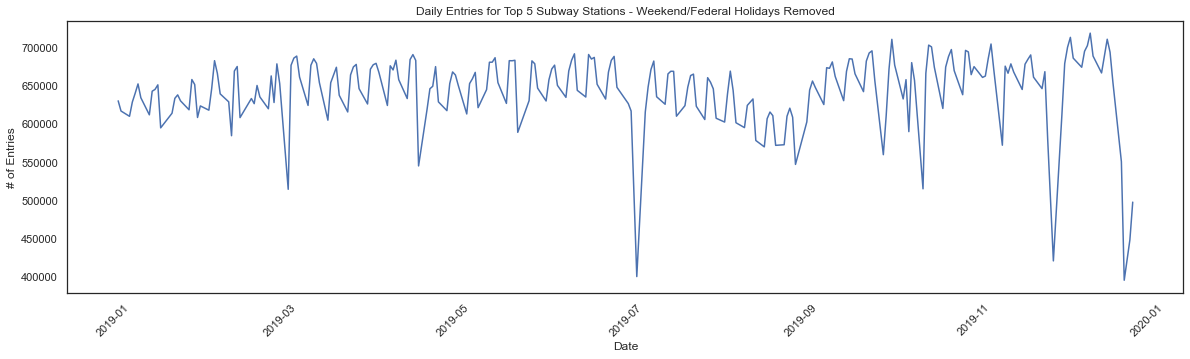

In [179]:
plt.figure(figsize=(20,5))
plt.plot(all_stations_weekday_nh['DATE'], all_stations_weekday_nh['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for Top 5 Subway Stations - Weekend/Federal Holidays Removed')
plt.savefig('daily_entries_combined.jpg')

In [151]:
# need to align dates of weather data with MTA data which ranges from 1/2/2019-12/27/2019
drop_dates = ['01/01/2019', '01/02/2019','12/28/2019', '12/29/2019','12/30/2019','12/31/2019']
pd.to_datetime(drop_dates)
weather_daily.drop(weather_daily[weather_daily['DATE'].isin(drop_dates)==True].index,inplace=True)
#just look at weekdays
weather_weekday = weather_daily[weather_daily['DATE'].dt.dayofweek.isin([0,1,2,3,4])]
#drop holidays
weather_weekday_nh = weather_weekday[((weather_weekday['DATE'].dt.date != holidays_2019[0]) &
                     (weather_weekday['DATE'].dt.date != holidays_2019[1]) &
                     (weather_weekday['DATE'].dt.date != holidays_2019[2]) &
                     (weather_weekday['DATE'].dt.date != holidays_2019[3]) &
                     (weather_weekday['DATE'].dt.date != holidays_2019[4]) &
                     (weather_weekday['DATE'].dt.date != holidays_2019[5])&
                     (weather_weekday['DATE'].dt.date != holidays_2019[6])) == True
                    ]


/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


#### Prepare weather data for rain and snow analysis - split out the values of no rain from light and heavy rain/snow.

In [152]:
def rain_snow_level (amount):
    if amount == 0:
        return 'No'
    elif amount > 0 and amount < 0.75:
        return 'Light'
    else :
        return 'Heavy'
weather_weekday_nh['RAIN_LEVEL'] = weather_weekday_nh['PRCP'].apply(rain_snow_level)
weather_weekday_nh['SNOW_LEVEL'] = weather_weekday_nh['SNOW'].apply(rain_snow_level)


/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/1032551311.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_weekday_nh['RAIN_LEVEL'] = weather_weekday_nh['PRCP'].apply(rain_snow_level)
/var/folders/w5/snb1bqfj60z575nq6s2nkrr40000gp/T/ipykernel_79856/1032551311.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_weekday_nh['SNOW_LEVEL'] = weather_weekday_nh['SNOW'].apply(rain_snow_level)


## Rain and Snow Impacts on Ridership

In [138]:
import seaborn as sns

<Figure size 1440x360 with 0 Axes>

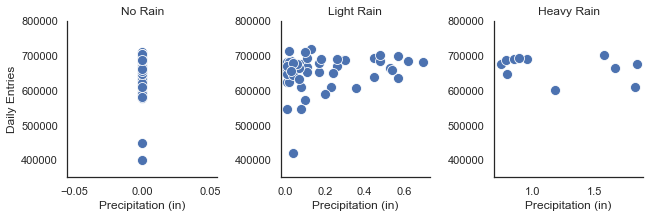

In [180]:
plt.figure(figsize=(20,5))
sns.set_theme(style="white")

rain = pd.concat([all_stations_weekday_nh['DATE'],all_stations_weekday_nh['DAILY_ENTRIES'],weather_weekday_nh["PRCP"],weather_weekday_nh['RAIN_LEVEL']],axis=1)
g = sns.FacetGrid(rain,col='RAIN_LEVEL',sharex=False,sharey=False,ylim=(350000,800000))
g.map_dataframe(sns.scatterplot,x="PRCP", y = "DAILY_ENTRIES",s=100)
g.set_axis_labels("Precipitation (in)", "Daily Entries")
g.set_titles(col_template='{col_name} Rain')
g.savefig('rain_impacts.jpg')
#                  data=rain)

In [154]:
weather_weekday_nh['PRCP'].corr(all_stations_weekday_nh['DAILY_ENTRIES'])

0.08979597806572318

<Figure size 1440x360 with 0 Axes>

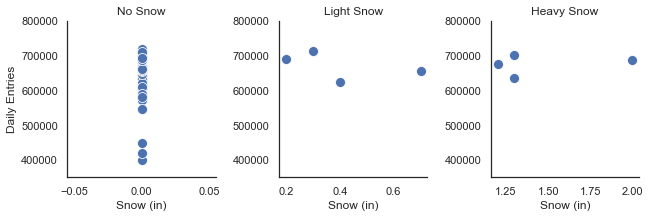

In [181]:
plt.figure(figsize=(20,5))
sns.set_theme(style="white")

rain = pd.concat([all_stations_weekday_nh['DATE'],all_stations_weekday_nh['DAILY_ENTRIES'],weather_weekday_nh["SNOW"],weather_weekday_nh['SNOW_LEVEL']],axis=1)
g = sns.FacetGrid(rain,col='SNOW_LEVEL',sharex=False,sharey=False,ylim=(350000,800000))
g.map_dataframe(sns.scatterplot,x="SNOW", y = "DAILY_ENTRIES",s=100)
g.set_axis_labels("Snow (in)", "Daily Entries")
g.set_titles(col_template='{col_name} Snow')
g.savefig('snow_impacts.jpg')


/Users/nbinowski/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SNOW', ylabel='DAILY_ENTRIES'>

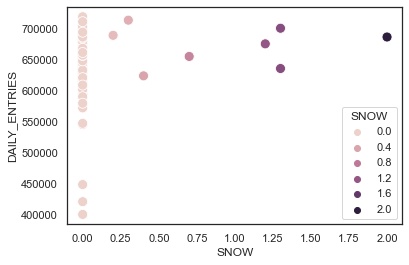

In [156]:
sns.scatterplot(rain.SNOW,rain.DAILY_ENTRIES,hue=rain.SNOW,s=100)

In [157]:
all_stations_weekday_nh['DAILY_ENTRIES'].corr(weather_weekday_nh['SNOW'])

0.07886262716844548

## Temperature Impacts on Ridership

### Impacts of High Temperatures on Ridership

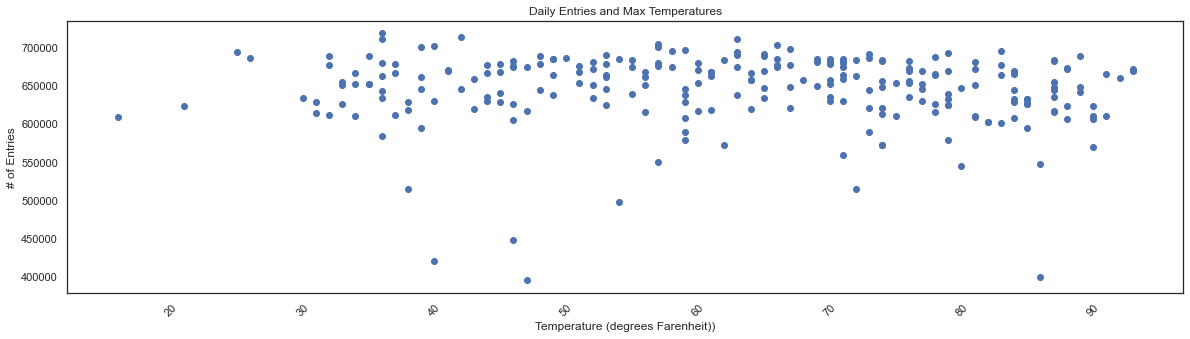

In [188]:
plt.figure(figsize=(20,5))
plt.scatter(weather_weekday_nh['TMAX'],all_stations_weekday_nh['DAILY_ENTRIES'])
#plt.scatter(all_stations_weekday_nh['DAILY_ENTRIES'],weather_weekday_nh['TMAX'])
plt.ylabel('# of Entries')
plt.xlabel('Temperature (degrees Farenheit))')
plt.xticks(rotation=45)
plt.title('Daily Entries and Max Temperatures')
plt.savefig('tmax_impacts.jpg')

In [160]:
all_stations_weekday_nh['DAILY_ENTRIES'].corr(weather_weekday_nh['TMAX'])

-0.11781333814319035

In [161]:
# See if drilling down makes a difference - look at summer months Jun-Aug
summer_months = [6,7,8]
summer_weather_daily = weather_weekday_nh[weather_weekday_nh["DATE"].dt.month.isin(summer_months) == True]
summer_all_stations_daily = all_stations_weekday_nh[all_stations_weekday_nh["DATE"].dt.month.isin(summer_months) == True]

summer_all_stations_daily['DAILY_ENTRIES'].corr(summer_weather_daily['TMAX'])

-0.24333363813753364

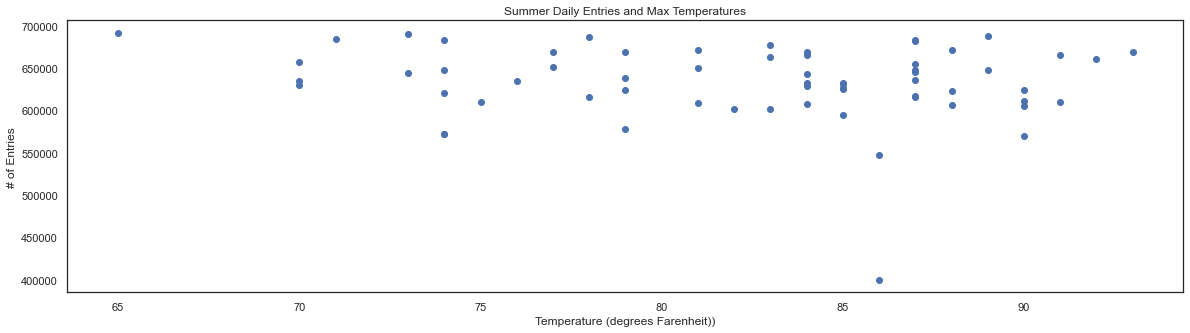

In [185]:
plt.figure(figsize=(20,5))
plt.scatter(summer_weather_daily['TMAX'],summer_all_stations_daily['DAILY_ENTRIES'])
#plt.scatter(all_stations_weekday_nh['DAILY_ENTRIES'],weather_weekday_nh['TMAX'])
plt.ylabel('# of Entries')
plt.xlabel('Temperature (degrees Farenheit))')
plt.title('Summer Daily Entries and Max Temperatures')
plt.savefig('tmax_summer_impacts.jpg')

### Impacts of Cold Temperatures on Ridership

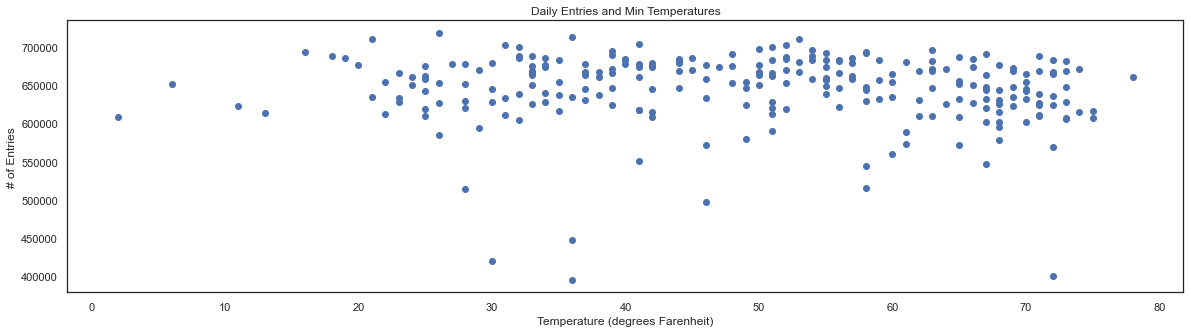

In [187]:
plt.figure(figsize=(20,5))
plt.scatter(weather_weekday_nh['TMIN'],all_stations_weekday_nh['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Temperature (degrees Farenheit)')

plt.title('Daily Entries and Min Temperatures')
plt.savefig('tmin_impacts.jpg')

In [165]:
all_stations_weekday_nh['DAILY_ENTRIES'].corr(weather_weekday_nh['TMIN'])

-0.11296316036699072

In [166]:
#Drill down to winter months
# See if drilling down makes a difference - look at summer months Jun-Aug
winter_months = [12,1,2]
winter_weather_daily = weather_weekday_nh[weather_weekday_nh["DATE"].dt.month.isin(winter_months) == True]
winter_all_stations_daily = all_stations_weekday_nh[all_stations_weekday_nh["DATE"].dt.month.isin(winter_months) == True]

winter_all_stations_daily['DAILY_ENTRIES'].corr(winter_weather_daily['TMIN'])

0.1510237667328395

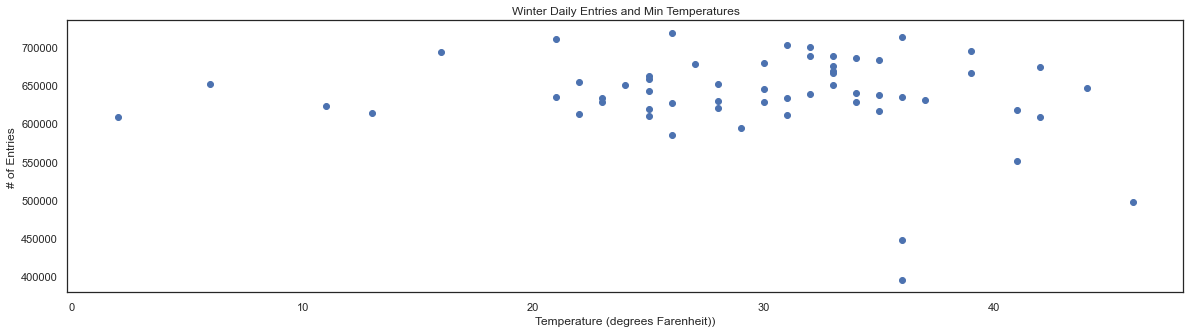

In [186]:
plt.figure(figsize=(20,5))
plt.scatter(winter_weather_daily['TMIN'],winter_all_stations_daily['DAILY_ENTRIES'])
#plt.scatter(all_stations_weekday_nh['DAILY_ENTRIES'],weather_weekday_nh['TMAX'])
plt.ylabel('# of Entries')
plt.xlabel('Temperature (degrees Farenheit))')
plt.title('Winter Daily Entries and Min Temperatures')
plt.savefig('tmin_winter_impacts.jpg')

In [196]:
num_heavy_snow_days = weather_weekday_nh[weather_weekday_nh.SNOW_LEVEL == 'Heavy'].SNOW_LEVEL.count()
print("Number of Heavy Snow Days:",num_heavy_snow_days)
num_heavy_rain_days = weather_weekday_nh[weather_weekday_nh.RAIN_LEVEL == 'Heavy'].RAIN_LEVEL.count()
print("Number of Heavy Rain Days:",num_heavy_rain_days)
num_hot_days = summer_weather_daily[summer_weather_daily.TMAX > 90].TMAX.count()
print("Number of Hot Days (>90):",num_hot_days)
num_cold_days = winter_weather_daily[winter_weather_daily.TMIN < 32].TMIN.count()
print("Number of Cold Days (<32):",num_cold_days)

Number of Heavy Snow Days: 5
Number of Heavy Rain Days: 18
Number of Hot Days (>90): 4
Number of Cold Days (<32): 31
